<div align="right">
Massimo Nocentini<br>
<br>September 8, 2016: big bang
</div>
<br>
<div align="center">
<b>Abstract</b><br>
This document describe our effort to perform mining techniques on the [OEIS][oeis].
</div>

[oeis]:http://oeis.org

**Imports**

The following cell import the function `oeis_search` in order to query the *Online Encyclopedia of Integer Sequences* and render search results directly in the current notebook; for a detailed tutorial, see http://nbviewer.jupyter.org/github/massimo-nocentini/competitive-programming/blob/master/tutorials/oeis-interaction.ipynb?flush_cache=true

In [146]:
from oeis import oeis_search

Follows `import`s required by this document.

In [147]:
from requests import get
import re
from itertools import count
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

# Sandbox

In [177]:
def oeis_graph(seq_id, depth=2):
        
    sink = {}
    
    def recursion(seq_id, step):
        
        payload = {"fmt": "json", "q": "id:A{:06d}".format(seq_id)}
        doc_result = get("https://oeis.org/search", params=payload,)
        doc = doc_result.json()
        result = doc['results'].pop()

        sink.update({seq_id: result})

        # preparing for recursion
        xrefs = result['xref'][:10] if 'xref' in result else []

        cross_references = set()
        regex = re.compile('(?P<id>A\d{6,6})')
        for xref in xrefs:
            cross_references |= set(int(r[1:]) for r in regex.findall(xref))

        result['xref_as_set'] = cross_references
        print("\ncross references of sequence id {}:\n{} ".format(seq_id, cross_references))
            
        if step < depth:
            for i, ref_seq_id in zip(count(), filter(lambda cr: cr not in sink, cross_references)):
                if i > 4: break
                recursion(ref_seq_id, step+1)
        
    recursion(seq_id, step=0)
    
    return sink


## Fibonacci

In [201]:
graph = oeis_graph(seq_id=45, depth=3)


cross references of sequence id 45:
{114690, 36355, 383, 94216, 90888, 152063, 100492, 99731, 254719, 7317, 104597, 101399, 101400, 59929, 1690, 39834, 144152, 157725, 157726, 157727, 288, 157728, 157729, 32, 930, 103323, 37027, 60455, 111006, 22307, 94638, 38575, 3893, 162741, 6327, 109754, 957, 99390, 167616, 322, 3269, 262342, 71, 1611, 249548, 48887, 74829, 105809, 109906, 213, 20695, 27926, 114197, 91867, 20701, 60441, 738, 101220, 105317, 744, 30186, 228074, 108, 118654, 234357, 57078, 1911, 92921, 94718, 71679} 

cross references of sequence id 114690:
{45, 5773, 1006, 114655} 

cross references of sequence id 5773:
{54393, 158973, 1700, 108, 1006, 5775, 2426, 132814, 245455, 136787, 57682, 5717, 5043, 54391, 54392, 62105, 55898, 26300, 1405, 38622} 

cross references of sequence id 54393:
{54391, 54392, 54394, 108, 5773, 1006} 

cross references of sequence id 158973:
{40, 36234, 720} 

cross references of sequence id 1700:
{49027, 30662, 2054, 102539, 28364, 5773, 132813, 134

In [202]:
graph.keys()

dict_keys([105728, 129, 114690, 36355, 4, 38149, 253318, 59841, 94216, 247561, 12, 5773, 142, 119725, 914, 27907, 81172, 119726, 20992, 1303, 247192, 288, 8275, 290, 37027, 1700, 5638, 166, 60455, 249026, 209705, 7623, 145324, 45, 6318, 90888, 3422, 1592, 84938, 53567, 114656, 322, 100683, 249413, 34886, 214727, 234696, 36681, 36682, 36683, 74829, 230607, 105809, 109906, 2003, 8276, 213, 54393, 217, 915, 231574, 114655, 228576, 48994, 228196, 241765, 48631, 253333, 60544, 108, 1006, 33428, 141523, 122189, 48887, 92921, 10050, 158973, 383])

In [209]:
G=nx.DiGraph()

G.add_nodes_from(graph.keys())

for seq_id, v in graph.items():
    for ref_seq_id in filter(lambda r: r in graph, v['xref_as_set']):
        G.add_edge(seq_id, ref_seq_id)

In [210]:
#G.nodes(), G.edges()

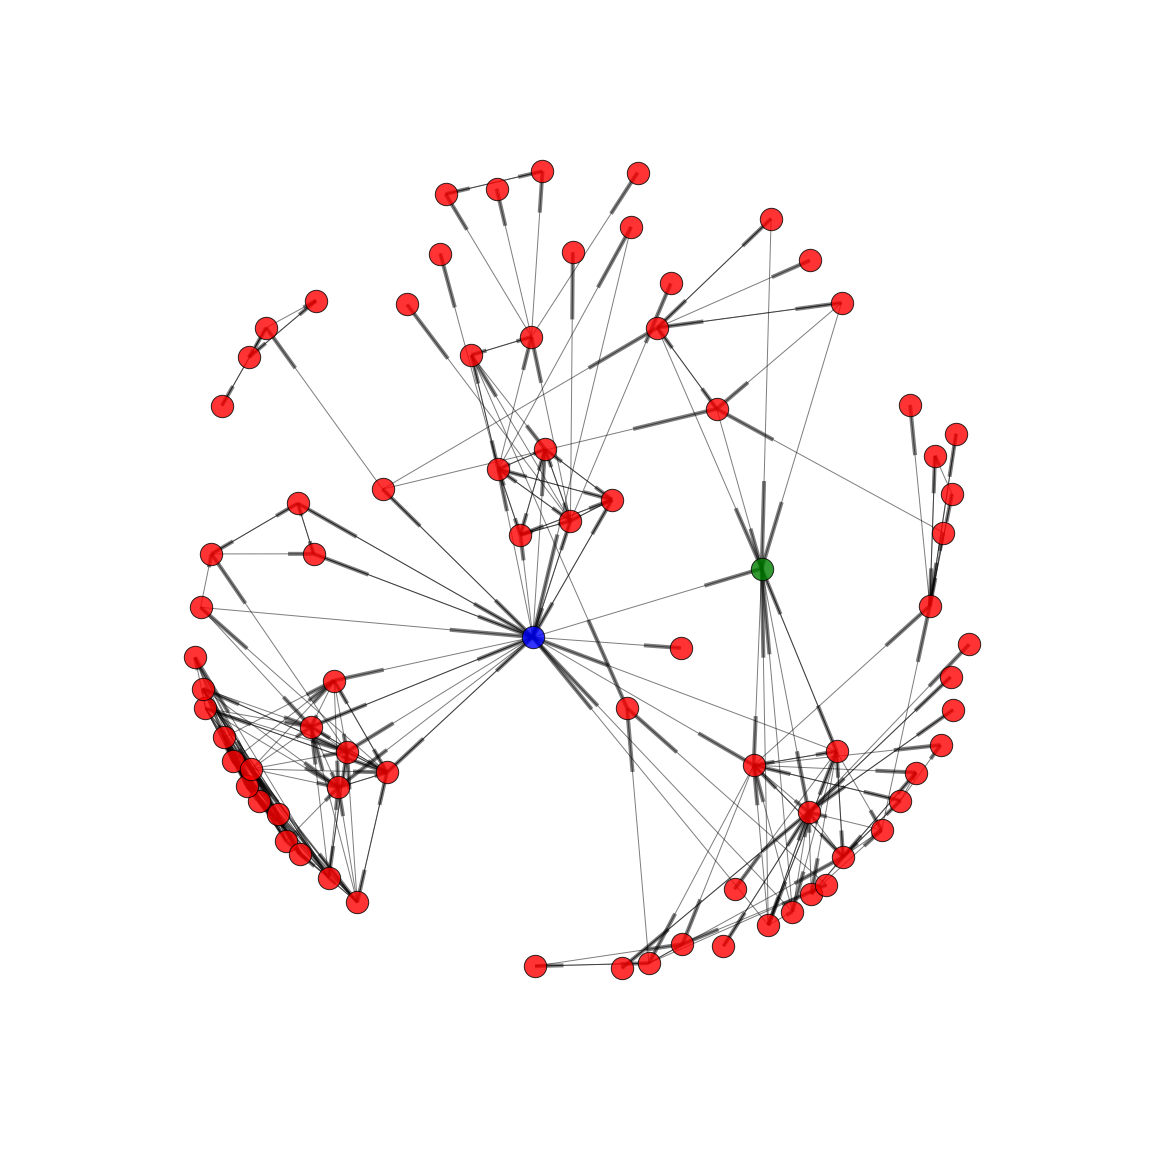

In [216]:
pos=nx.spring_layout(G)#, iterations=200) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[45],#fibonacci
                       node_color='b',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=[108],#catalan
                       node_color='g',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=set(graph.keys())-set([45, 108]),
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
plt.axis('off')
plt.show() # display

## Catalan

In [217]:
graph = oeis_graph(seq_id=108, depth=3)


cross references of sequence id 108:
{69640, 2057, 94216, 68875, 176137, 142, 119822, 33552, 99731, 14486, 59288, 22553, 211611, 30237, 33184, 1699, 98597, 1190, 9766, 24492, 1453, 94638, 39599, 94639, 161581, 60854, 14137, 14138, 32443, 14140, 3517, 957, 3519, 3518, 154559, 106566, 588, 179277, 6480, 81, 8276, 167892, 167893, 984, 344, 48990, 99039, 47072, 137697, 51168, 129763, 130020, 8549, 3046, 32357, 86117, 59365, 1003, 120303, 1392, 120304, 753, 121839, 2420, 245, 736, 124926, 1791} 

cross references of sequence id 69640:
{67689, 5249, 74962, 108, 3046} 

cross references of sequence id 67689:
{984, 5249, 60739} 

cross references of sequence id 984:
{182400, 30662, 8459, 261009, 51924, 2457, 59481, 25565, 226078, 158815, 2144, 81696, 152229, 71976, 214377, 108, 258290, 135091, 2420, 98616, 205946, 1405, 226302} 

cross references of sequence id 5249:
{74962, 60739, 515, 69945, 56040, 67689, 163085} 

cross references of sequence id 60739:
{67689, 5249, 1700} 

cross reference

In [218]:
graph.keys()

dict_keys([27907, 4, 5638, 129, 69640, 2057, 68875, 12, 33552, 1303, 30237, 239903, 5408, 290, 244230, 9766, 244231, 71724, 94216, 176137, 197433, 53567, 243264, 243265, 10050, 60739, 106566, 65096, 588, 8275, 8276, 344, 3422, 59365, 48994, 30308, 241765, 40000, 3945, 108, 3517, 255344, 2420, 145598, 67689, 122, 3519, 161227, 166, 60544, 5249, 55746, 142, 262543, 914, 915, 33428, 33184, 1392, 674, 1699, 34886, 1190, 145324, 178, 145596, 145597, 3518, 145599, 145600, 59841, 249026, 35011, 54726, 7623, 84938, 51575, 244232, 74962, 161239, 984, 217, 51675, 99039, 47072, 130020, 108838, 3046, 3047, 1003, 245, 48631])

In [219]:
G=nx.DiGraph()

G.add_nodes_from(graph.keys())

for seq_id, v in graph.items():
    for ref_seq_id in filter(lambda r: r in graph, v['xref_as_set']):
        G.add_edge(seq_id, ref_seq_id)

In [220]:
#G.nodes(), G.edges()

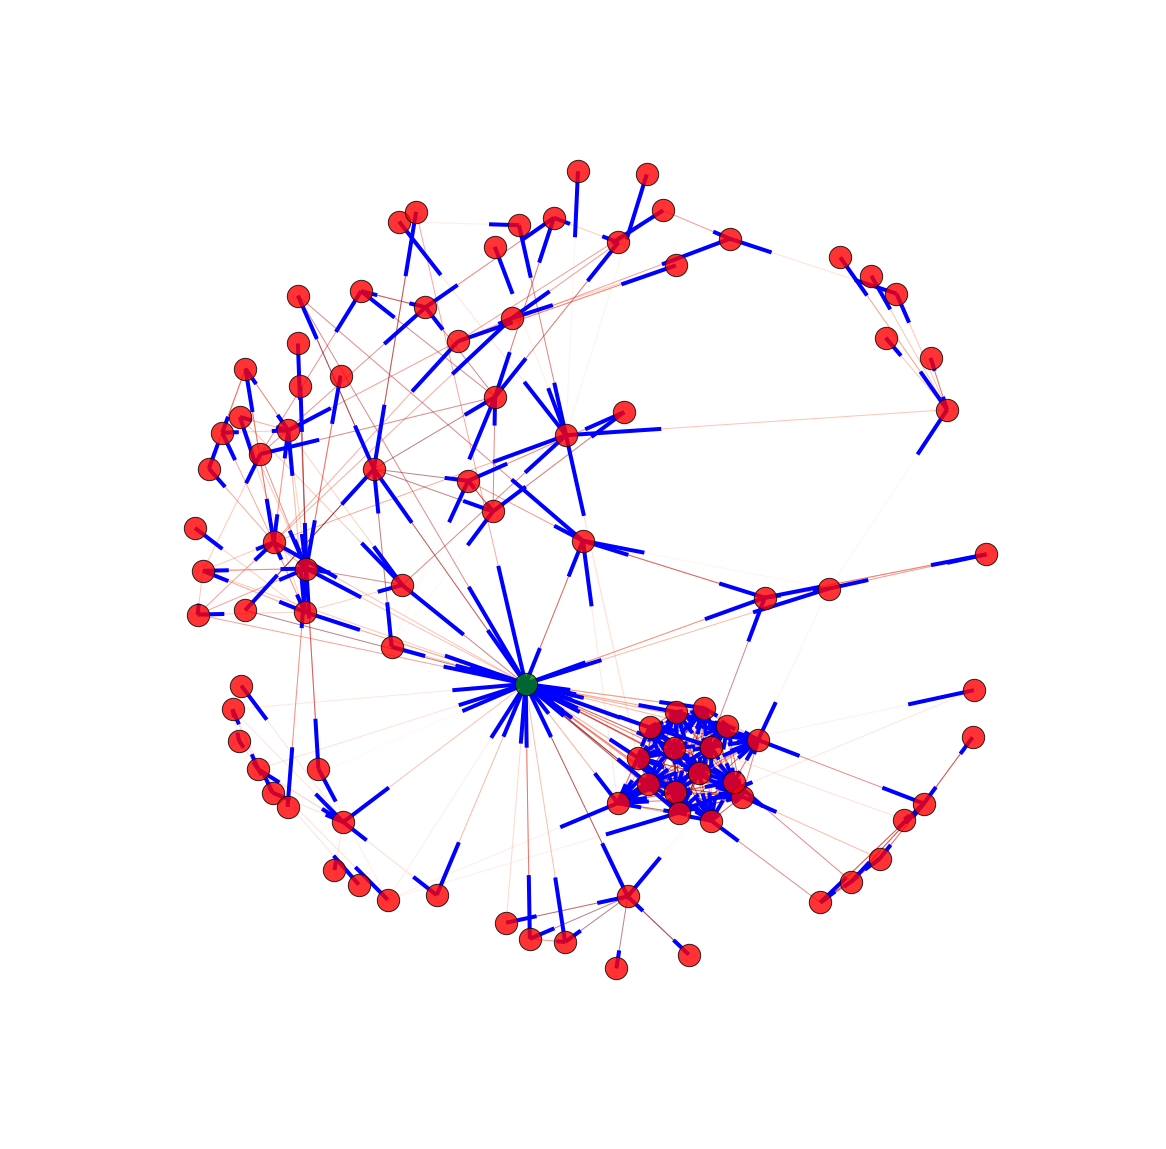

In [240]:
pos=nx.spring_layout(G)#, iterations=200) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=[108],#catalan
                       node_color='g',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist=set(graph.keys())-set([45, 108]),
                       node_color='r',
                       node_size=500,
                   alpha=0.8)
nx.draw_networkx_edges(G,pos,width=1,alpha=.5,edge_color=range(len(G.edges())), edge_cmap=plt.cm.Reds)
plt.axis('off')
plt.show() # display

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.